In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statistics

In [2]:
import sys
import os

from pathlib import Path

parent = Path(os.path.abspath("")).resolve().parents[0]
if parent not in sys.path:
    sys.path.insert(0, str(parent))

import random 
from types import SimpleNamespace

import torch

from torch.utils.data import DataLoader

from models.autoencoder import VariationalAutoEncoder, AutoEncoder
from models.mlp import MLP
from utils.data_utils import TorchDataset

from utils.metrics import get_classification_metrics, get_probability_measures, get_lift_demotion_scores

import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler
import numpy as np

In [3]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
thefts = pd.read_csv("../dataset/final/valid_train_thefts.csv")
non_thefts = pd.read_csv("../dataset/final/valid_train_non_theft_suc_theft_acct.csv")

df = pd.concat([thefts, non_thefts])
df.drop(columns=['acct', 'successor', 'voltage'], inplace=True)
df.fillna(-1, inplace=True)

In [5]:
scaler = MinMaxScaler()

In [6]:
#df.drop(['xrhsh', 'parno', 'acct_control', 'contract_capacity', 'min_measurement_interval_in_days', 'max_energy_per_day'], axis=1, inplace=True)
print("Bincount of y:", df['target'].value_counts())

Bincount of y: 0    2094
1    1555
Name: target, dtype: int64


In [7]:
df.head()

,number_of_measurements,number_of_zeros,max_energy_per_day,min_energy_per_day,mean_energy_per_day,median_energy_per_day,std_energy_per_day,max_measurement_interval_in_days,min_measurement_interval_in_days,mean_measurement_interval_in_days,median_measurement_interval_in_days,days_since_last_measurement,parno,xrhsh,contract_capacity,acct_control,number_of_requests,target
0,12,2,18.950000,0.000000,6.735356,7.049180,4.964937,350,15,144.181818,122.0,152,0,1,12.0,0,0,1
1,13,2,12.071429,0.000000,7.221644,10.070525,4.807979,243,6,122.416667,121.0,341,0,1,12.0,0,1,1
2,5,5,0.000000,0.000000,0.000000,0.000000,0.000000,125,120,122.250000,122.0,1251,2,1,25.0,0,3,1
3,6,1,9.434066,4.546448,5.873035,4.989218,1.803735,371,68,197.200000,182.0,190,2,6,25.0,0,0,1
4,8,0,19.565574,1.910569,10.585130,10.008197,5.580233,246,121,139.142857,121.0,821,3,1,35.0,0,5,1


In [8]:
train = df[df['target'] == 1]
train, val = train_test_split(train, test_size=0.2, random_state=42, shuffle=True)

test_target0 = df[(df['target'] == 0)]

In [9]:
train.target.value_counts(), val.target.value_counts(), test_target0.target.value_counts()

(1    1244
 Name: target, dtype: int64,
 1    311
 Name: target, dtype: int64,
 0    2094
 Name: target, dtype: int64)

In [10]:
X_train = train.drop('target', axis=1)
y_train = train['target']
X_val = val.drop('target', axis=1)
y_val = val['target']
X_test_0 = test_target0.drop('target', axis=1)
y_test_0 = test_target0['target']

In [11]:
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test_0 = scaler.transform(X_test_0)

In [12]:
train_dataset = TorchDataset(
    X=torch.tensor(X_train).float(),
    y=torch.tensor(y_train.to_numpy()).float()
)  # reconstruction
val_dataset = TorchDataset(
    X=torch.tensor(X_val).float(),
    y=torch.tensor(y_val.to_numpy()).float()
)

test_dataset_zero = TorchDataset(
    X=torch.tensor(X_test_0).float(),
    y=torch.tensor(y_test_0.to_numpy()).float()
)

X_test = np.concatenate([X_val, X_test_0], axis=0)
y_test = pd.concat([y_val, y_test_0])
test_dataset = TorchDataset(
    X=torch.tensor(X_test).float(),
    y=torch.tensor(y_test.to_numpy()).float()
)

In [13]:
np.bincount(y_train), np.bincount(y_val), np.bincount(y_test)

(array([   0, 1244]), array([  0, 311]), array([2094,  311]))

In [14]:
train_loader = DataLoader(
    train_dataset, batch_size=32, shuffle=False
)
val_loader = DataLoader(
    val_dataset, batch_size=32, shuffle=False
)
test_loader = DataLoader(
    test_dataset, batch_size=1, shuffle=False
)
test_zero = DataLoader(
    test_dataset_zero, batch_size=1, shuffle=False
)

In [15]:
encoder = MLP(
    in_size=X_train.shape[1],
    layer_units=[16, 8],
    out_size=4,
    vae=False)
decoder = MLP(
    in_size=4, 
    layer_units=[8, 16],
    out_size=X_train.shape[1]
)
model = AutoEncoder(encoder, decoder)
model

AutoEncoder(
  (encoder): MLP(
    (MLP): Sequential(
      (0): Linear(in_features=17, out_features=16, bias=True)
      (1): ReLU()
      (2): Linear(in_features=16, out_features=8, bias=True)
      (3): ReLU()
      (4): Linear(in_features=8, out_features=4, bias=True)
    )
  )
  (decoder): MLP(
    (MLP): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=16, bias=True)
      (3): ReLU()
      (4): Linear(in_features=16, out_features=17, bias=True)
    )
  )
)

In [16]:
optimizer = torch.optim.Adam(model.parameters(), 
                                 lr=1e-3, weight_decay=1e-5)
criterion = torch.nn.SmoothL1Loss()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    
args = dict(model=model, train_loader=train_loader, 
            test_loader=val_loader,
            epochs=1_000, optimizer=optimizer, 
            criterion=criterion,
            reconstruction=True, vae=False,
            device=device, verbose=True, return_best=True)

Epoch: 1/1000
[Train]	Loss=0.08760304538867413
[Test]	Loss=0.07904114350676536

Epoch: 2/1000
[Train]	Loss=0.055727157598504655
[Test]	Loss=0.027668138965964317

Epoch: 3/1000
[Train]	Loss=0.014489095216282668
[Test]	Loss=0.009265922289341689

Epoch: 4/1000
[Train]	Loss=0.008398222534033732
[Test]	Loss=0.008403664547950029

Epoch: 5/1000
[Train]	Loss=0.007987216353798524
[Test]	Loss=0.008122484618797898

Epoch: 6/1000
[Train]	Loss=0.007790661882609129
[Test]	Loss=0.007976313959807158

Epoch: 7/1000
[Train]	Loss=0.007654063236445953
[Test]	Loss=0.007848317502066493

Epoch: 8/1000
[Train]	Loss=0.007511761135015733
[Test]	Loss=0.00770563785918057

Epoch: 9/1000
[Train]	Loss=0.0073324015292410664
[Test]	Loss=0.007517844066023826

Epoch: 10/1000
[Train]	Loss=0.007073733609360762
[Test]	Loss=0.007235919265076518

Epoch: 11/1000
[Train]	Loss=0.006667162208125377
[Test]	Loss=0.006767989182844758

Epoch: 12/1000
[Train]	Loss=0.006067207781597972
[Test]	Loss=0.006171858520247042

Epoch: 13/1000


Epoch: 101/1000
[Train]	Loss=0.0014632596091056864
[Test]	Loss=0.0020745139569044112

Epoch: 102/1000
[Train]	Loss=0.0014522799875778265
[Test]	Loss=0.002069060131907463

Epoch: 103/1000
[Train]	Loss=0.0014413717092396931
[Test]	Loss=0.0020619811315555126

Epoch: 104/1000
[Train]	Loss=0.0014314244244581996
[Test]	Loss=0.002057426463579759

Epoch: 105/1000
[Train]	Loss=0.0014192114408032443
[Test]	Loss=0.002050968533148989

Epoch: 106/1000
[Train]	Loss=0.0014087850726448381
[Test]	Loss=0.0020450317242648453

Epoch: 107/1000
[Train]	Loss=0.0013987725609555268
[Test]	Loss=0.0020352767838630824

Epoch: 108/1000
[Train]	Loss=0.001389771716322941
[Test]	Loss=0.0020311395986936987

Epoch: 109/1000
[Train]	Loss=0.0013786557052905362
[Test]	Loss=0.002027018589433283

Epoch: 110/1000
[Train]	Loss=0.001369469161802091
[Test]	Loss=0.0020220751175656915

Epoch: 111/1000
[Train]	Loss=0.0013607346022931428
[Test]	Loss=0.0020186263718642294

Epoch: 112/1000
[Train]	Loss=0.0013518880184095066
[Test]	Lo

Epoch: 199/1000
[Train]	Loss=0.0010433299974418986
[Test]	Loss=0.0016928688331972809

Epoch: 200/1000
[Train]	Loss=0.0010425905019450837
[Test]	Loss=0.0016929485776927323

Epoch: 201/1000
[Train]	Loss=0.001041914114000228
[Test]	Loss=0.0016904763178899884

Epoch: 202/1000
[Train]	Loss=0.0010405791571172767
[Test]	Loss=0.001688839856069535

Epoch: 203/1000
[Train]	Loss=0.0010392989840907736
[Test]	Loss=0.001687421282986179

Epoch: 204/1000
[Train]	Loss=0.0010386148037818761
[Test]	Loss=0.0016847446793690323

Epoch: 205/1000
[Train]	Loss=0.0010378710561408065
[Test]	Loss=0.0016834277077578009

Epoch: 206/1000
[Train]	Loss=0.0010367430036123365
[Test]	Loss=0.0016834245063364506

Epoch: 207/1000
[Train]	Loss=0.0010358556397617436
[Test]	Loss=0.0016804633603896945

Epoch: 208/1000
[Train]	Loss=0.0010354547352434541
[Test]	Loss=0.0016792860173154623

Epoch: 209/1000
[Train]	Loss=0.0010340198134191525
[Test]	Loss=0.001676918496377766

Epoch: 210/1000
[Train]	Loss=0.0010330615078624433
[Test]	

Epoch: 295/1000
[Train]	Loss=0.0009856267566553866
[Test]	Loss=0.0016302829724736511

Epoch: 296/1000
[Train]	Loss=0.0009854364146191913
[Test]	Loss=0.0016306467237882315

Epoch: 297/1000
[Train]	Loss=0.0009852154792334216
[Test]	Loss=0.0016295239562168717

Epoch: 298/1000
[Train]	Loss=0.0009845792068144642
[Test]	Loss=0.0016308288555592298

Epoch: 299/1000
[Train]	Loss=0.0009841508446977688
[Test]	Loss=0.0016299711365718394

Epoch: 300/1000
[Train]	Loss=0.000984182915626428
[Test]	Loss=0.0016308194841258227

Epoch: 301/1000
[Train]	Loss=0.000984139807629757
[Test]	Loss=0.0016304214484989643

Epoch: 302/1000
[Train]	Loss=0.0009837122111676787
[Test]	Loss=0.0016307778074406087

Epoch: 303/1000
[Train]	Loss=0.0009826926368240935
[Test]	Loss=0.00163026072550565

Epoch: 304/1000
[Train]	Loss=0.0009828515914985193
[Test]	Loss=0.0016322535695508123

Epoch: 305/1000
[Train]	Loss=0.000982721618269212
[Test]	Loss=0.0016329365607816726

Epoch: 306/1000
[Train]	Loss=0.0009823523324508315
[Test]	L

Epoch: 393/1000
[Train]	Loss=0.0009628521556106324
[Test]	Loss=0.0016703007160685957

Epoch: 394/1000
[Train]	Loss=0.000961794904492891
[Test]	Loss=0.0016651499550789594

Epoch: 395/1000
[Train]	Loss=0.0009613457338836712
[Test]	Loss=0.0016729014692828058

Epoch: 396/1000
[Train]	Loss=0.0009608552373277071
[Test]	Loss=0.0016694502963218838

Epoch: 397/1000
[Train]	Loss=0.0009607128016889477
[Test]	Loss=0.001668978331144899

Epoch: 398/1000
[Train]	Loss=0.0009614578209435329
[Test]	Loss=0.0016710456344299018

Epoch: 399/1000
[Train]	Loss=0.0009604103591603538
[Test]	Loss=0.0016665898205246777

Epoch: 400/1000
[Train]	Loss=0.0009604226618718642
[Test]	Loss=0.001674892334267497

Epoch: 401/1000
[Train]	Loss=0.0009600822694408587
[Test]	Loss=0.001672066788887605

Epoch: 402/1000
[Train]	Loss=0.0009599590378526885
[Test]	Loss=0.0016712192737031728

Epoch: 403/1000
[Train]	Loss=0.000960324107346913
[Test]	Loss=0.0016711813572328539

Epoch: 404/1000
[Train]	Loss=0.000959232862955198
[Test]	Lo

Epoch: 491/1000
[Train]	Loss=0.0009375900934593609
[Test]	Loss=0.0016524487815331667

Epoch: 492/1000
[Train]	Loss=0.0009367027176687351
[Test]	Loss=0.0016479284910019486

Epoch: 493/1000
[Train]	Loss=0.0009364201448475703
[Test]	Loss=0.0016507946944329887

Epoch: 494/1000
[Train]	Loss=0.000935954820866195
[Test]	Loss=0.001648990239482373

Epoch: 495/1000
[Train]	Loss=0.0009352888386601057
[Test]	Loss=0.0016503786609973758

Epoch: 496/1000
[Train]	Loss=0.0009361713832148757
[Test]	Loss=0.0016487771354150027

Epoch: 497/1000
[Train]	Loss=0.0009352193073703883
[Test]	Loss=0.0016476658056490123

Epoch: 498/1000
[Train]	Loss=0.000935154289413148
[Test]	Loss=0.001649421197362244

Epoch: 499/1000
[Train]	Loss=0.0009357052667138095
[Test]	Loss=0.0016492432507220656

Epoch: 500/1000
[Train]	Loss=0.0009346055016160393
[Test]	Loss=0.001648790470790118

Epoch: 501/1000
[Train]	Loss=0.0009354198611198136
[Test]	Loss=0.0016475786862429232

Epoch: 502/1000
[Train]	Loss=0.0009344995323305902
[Test]	L

Epoch: 589/1000
[Train]	Loss=0.0009169717504380223
[Test]	Loss=0.0016106453898828478

Epoch: 590/1000
[Train]	Loss=0.0009172125973213369
[Test]	Loss=0.0016111149219796062

Epoch: 591/1000
[Train]	Loss=0.0009163761905466134
[Test]	Loss=0.0016106458671856672

Epoch: 592/1000
[Train]	Loss=0.0009161476896574291
[Test]	Loss=0.0016112641722429543

Epoch: 593/1000
[Train]	Loss=0.0009158949699037924
[Test]	Loss=0.001609815371921286

Epoch: 594/1000
[Train]	Loss=0.0009153110037844342
[Test]	Loss=0.001610546256415546

Epoch: 595/1000
[Train]	Loss=0.0009150952667905352
[Test]	Loss=0.0016083274269476533

Epoch: 596/1000
[Train]	Loss=0.0009145519430510318
[Test]	Loss=0.0016081165755167603

Epoch: 597/1000
[Train]	Loss=0.0009142885623404231
[Test]	Loss=0.0016085391107480973

Epoch: 598/1000
[Train]	Loss=0.0009143481669851985
[Test]	Loss=0.0016068584460299461

Epoch: 599/1000
[Train]	Loss=0.0009141476520408804
[Test]	Loss=0.001605637522879988

Epoch: 600/1000
[Train]	Loss=0.0009139811214155111
[Test]

Epoch: 685/1000
[Train]	Loss=0.0008625866955695435
[Test]	Loss=0.0015291876625269651

Epoch: 686/1000
[Train]	Loss=0.0008619642780663875
[Test]	Loss=0.0015280337305739523

Epoch: 687/1000
[Train]	Loss=0.0008630016564916915
[Test]	Loss=0.0015273978584446012

Epoch: 688/1000
[Train]	Loss=0.0008608287122721473
[Test]	Loss=0.001528727897675708

Epoch: 689/1000
[Train]	Loss=0.0008600584846228743
[Test]	Loss=0.0015307482972275466

Epoch: 690/1000
[Train]	Loss=0.0008605980621770215
[Test]	Loss=0.0015286055393517017

Epoch: 691/1000
[Train]	Loss=0.0008594545473058063
[Test]	Loss=0.0015285136818420143

Epoch: 692/1000
[Train]	Loss=0.0008583964723257873
[Test]	Loss=0.001530182105489075

Epoch: 693/1000
[Train]	Loss=0.0008582730661146343
[Test]	Loss=0.0015265609021298588

Epoch: 694/1000
[Train]	Loss=0.0008594063737501318
[Test]	Loss=0.0015247874893248082

Epoch: 695/1000
[Train]	Loss=0.0008570898595886925
[Test]	Loss=0.0015254590020049364

Epoch: 696/1000
[Train]	Loss=0.000856873001724195
[Test]

Epoch: 781/1000
[Train]	Loss=0.0008261148393966067
[Test]	Loss=0.0014664428716059774

Epoch: 782/1000
[Train]	Loss=0.0008260703821762059
[Test]	Loss=0.0014719208818860352

Epoch: 783/1000
[Train]	Loss=0.0008247600456413168
[Test]	Loss=0.0014685267524328083

Epoch: 784/1000
[Train]	Loss=0.0008254110431059813
[Test]	Loss=0.0014628576696850359

Epoch: 785/1000
[Train]	Loss=0.0008252114893343204
[Test]	Loss=0.0014632037025876343

Epoch: 786/1000
[Train]	Loss=0.0008246999335451386
[Test]	Loss=0.0014663904847111553

Epoch: 787/1000
[Train]	Loss=0.000824201507314753
[Test]	Loss=0.0014681458211271091

Epoch: 788/1000
[Train]	Loss=0.0008237516411986107
[Test]	Loss=0.0014635037747211753

Epoch: 789/1000
[Train]	Loss=0.0008238756772465048
[Test]	Loss=0.0014659682638011873

Epoch: 790/1000
[Train]	Loss=0.000823400454977766
[Test]	Loss=0.0014663639449281618

Epoch: 791/1000
[Train]	Loss=0.0008233710526464841
[Test]	Loss=0.001465358104906045

Epoch: 792/1000
[Train]	Loss=0.0008238959767951224
[Test]

Epoch: 877/1000
[Train]	Loss=0.0008085696981885495
[Test]	Loss=0.0014436981407925486

Epoch: 878/1000
[Train]	Loss=0.0008087601327600005
[Test]	Loss=0.0014461401588050649

Epoch: 879/1000
[Train]	Loss=0.0008082798583647952
[Test]	Loss=0.0014427082758629694

Epoch: 880/1000
[Train]	Loss=0.0008082144135513749
[Test]	Loss=0.0014409319235710427

Epoch: 881/1000
[Train]	Loss=0.0008078063465057848
[Test]	Loss=0.0014438715239521115

Epoch: 882/1000
[Train]	Loss=0.0008070921011937734
[Test]	Loss=0.001446591320564039

Epoch: 883/1000
[Train]	Loss=0.0008072092762002005
[Test]	Loss=0.0014427523215999826

Epoch: 884/1000
[Train]	Loss=0.0008074258818315008
[Test]	Loss=0.0014449853188125417

Epoch: 885/1000
[Train]	Loss=0.0008066582377068698
[Test]	Loss=0.001442060954286717

Epoch: 886/1000
[Train]	Loss=0.000807478306038926
[Test]	Loss=0.0014418351609492674

Epoch: 887/1000
[Train]	Loss=0.000807134103244887
[Test]	Loss=0.001444700377760455

Epoch: 888/1000
[Train]	Loss=0.0008064992128847501
[Test]	L

Epoch: 973/1000
[Train]	Loss=0.0007986961893785077
[Test]	Loss=0.0014394142461242154

Epoch: 974/1000
[Train]	Loss=0.0007984571708127474
[Test]	Loss=0.001439737287000753

Epoch: 975/1000
[Train]	Loss=0.0007979558819594482
[Test]	Loss=0.0014405723195523024

Epoch: 976/1000
[Train]	Loss=0.0007981772710664723
[Test]	Loss=0.0014384192239958794

Epoch: 977/1000
[Train]	Loss=0.0007993370109500411
[Test]	Loss=0.0014417388010770082

Epoch: 978/1000
[Train]	Loss=0.0007991091100475154
[Test]	Loss=0.001442198664881289

Epoch: 979/1000
[Train]	Loss=0.0007980438083625183
[Test]	Loss=0.0014399612322449685

Epoch: 980/1000
[Train]	Loss=0.0007981085397589665
[Test]	Loss=0.0014393813587957993

Epoch: 981/1000
[Train]	Loss=0.0007982054182017843
[Test]	Loss=0.0014416020130738616

Epoch: 982/1000
[Train]	Loss=0.0007979821574945862
[Test]	Loss=0.0014443826890783384

Epoch: 983/1000
[Train]	Loss=0.0007981051278945345
[Test]	Loss=0.0014414305362151936

Epoch: 984/1000
[Train]	Loss=0.0007984218969702339
[Test

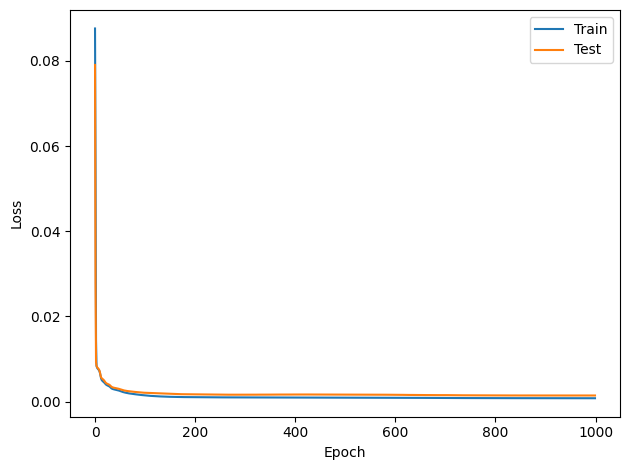

In [17]:
args = SimpleNamespace(**args)
model = model.fit(args)

In [18]:
tmp_train_loader = DataLoader(
    train_dataset, batch_size=1, shuffle=False
)
tmp_val_loader = DataLoader(
    val_dataset, batch_size=1, shuffle=False
)

In [19]:
def make_preds(model, data_loader):
    loss_dist = []
    model.eval()
    for x, _ in data_loader:
        x = x.to(device)
        sample = model(x)
        loss = torch.nn.MSELoss()(x, sample)
        loss_dist.append(loss.item())
    return loss_dist  

In [20]:
def plot_loss_dist(loss_dist):
    loss = []
    for i in loss_dist:
        loss.append((i,i))
    plt.scatter(*zip(*loss))
    plt.show()
    plt.close()

In [21]:
train_loss_dist = make_preds(model, tmp_train_loader)

In [22]:
len(train_loss_dist)

1244

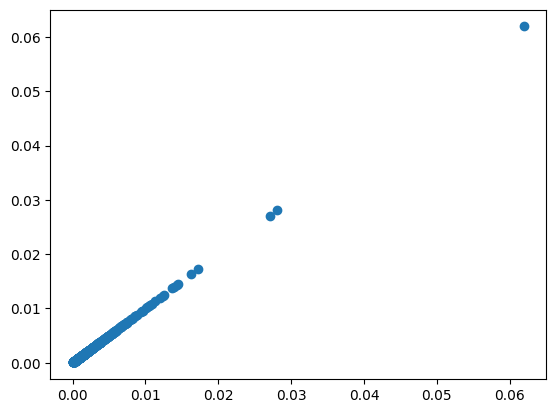

In [23]:
plot_loss_dist(train_loss_dist)

311


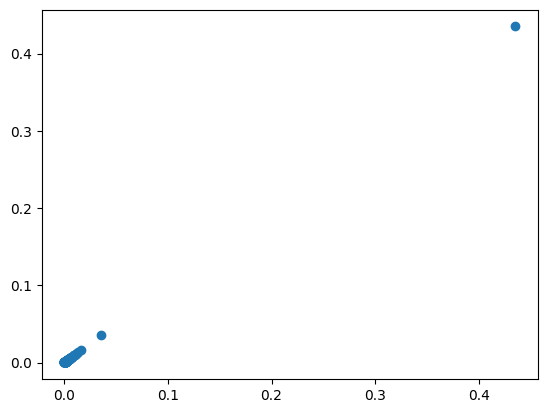

In [24]:
val_loss_dist = make_preds(model, tmp_val_loader)
print(len(val_loss_dist))
plot_loss_dist(val_loss_dist)

In [25]:
sorted_train = sorted(train_loss_dist, reverse=True)
print("Train", sorted_train[:10])
print("\n\n")

sorted_val = sorted(val_loss_dist, reverse=True)
print("Val", sorted_val[:10])
print("\n\n")

print(f"Train Mean: {statistics.mean(train_loss_dist)}, Median: {statistics.median(train_loss_dist)}")
print(f"Val Mean: {statistics.mean(val_loss_dist)}, Median: {statistics.mean(val_loss_dist)}")

Train [0.06195838376879692, 0.028059838339686394, 0.0270990077406168, 0.017250051721930504, 0.016284719109535217, 0.014528396539390087, 0.014299132861196995, 0.013951893895864487, 0.013703444041311741, 0.012555786408483982]



Val [0.43498465418815613, 0.03574201837182045, 0.01643005572259426, 0.013588988222181797, 0.012548418715596199, 0.011444341391324997, 0.009939276613295078, 0.009638426825404167, 0.009242457337677479, 0.009154479019343853]



Train Mean: 0.001576687930224533, Median: 0.0008353896555490792
Val Mean: 0.003075304728039631, Median: 0.003075304728039631


2094


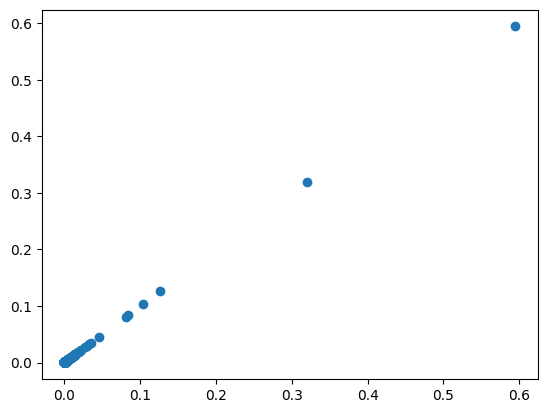

In [26]:
test_zero_loss_dist = make_preds(model, test_zero)
print(len(test_zero_loss_dist))
plot_loss_dist(test_zero_loss_dist)

In [27]:
sorted_test = sorted(test_zero_loss_dist, reverse=True)
print("Test zero", sorted_test[:10])
print("\n\n")

print(f"Test Mean: {statistics.mean(test_zero_loss_dist)}, Median: {statistics.median(test_zero_loss_dist)}")

Test zero [0.5945272445678711, 0.3200456202030182, 0.12616084516048431, 0.10371662676334381, 0.0843609943985939, 0.08085411787033081, 0.04533753544092178, 0.03522052988409996, 0.03325978294014931, 0.02955356054008007]



Test Mean: 0.0023408204382569563, Median: 0.0011528171016834676


In [28]:
np.percentile(train_loss_dist, 20), np.percentile(val_loss_dist, 20), np.percentile(test_zero_loss_dist, 20)

(0.00041289679938927293, 0.00041574324131943285, 0.0005158455576747655)

In [29]:
zero_below, zero_above = [], [] 
for i in test_zero_loss_dist:
    if i < 0.0004:
        zero_below.append(i)
    else:
        zero_above.append(i)
len(zero_below), len(zero_above)

(261, 1833)

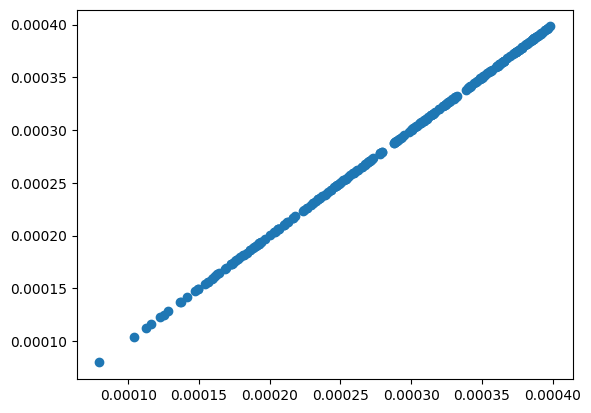

In [30]:
plot_loss_dist(zero_below)

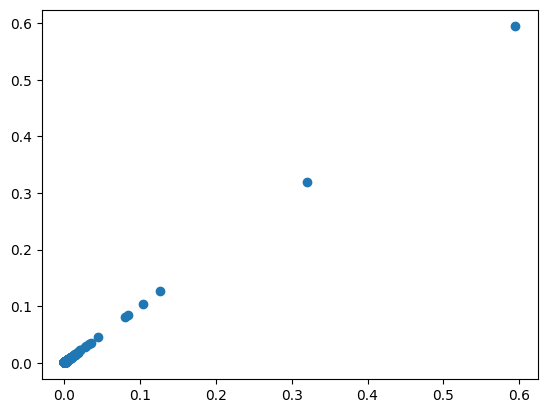

In [31]:
plot_loss_dist(zero_above)

In [32]:
test_loss_dist = make_preds(model, test_loader)
len(test_loss_dist)

2405

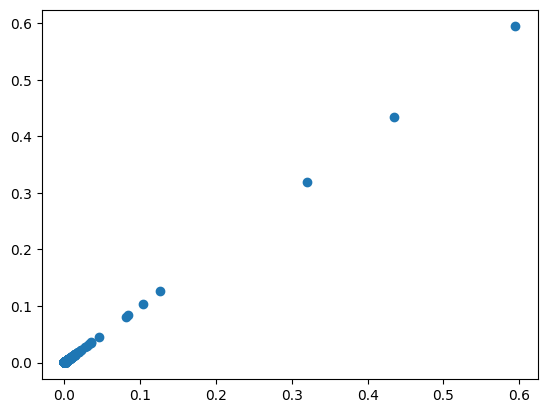

In [33]:
plot_loss_dist(test_loss_dist)

In [34]:
#total_losses = train_loss_dist[:]
#total_losses.extend(test_loss_dist)
total_losses = test_loss_dist
total_losses = np.array(total_losses)

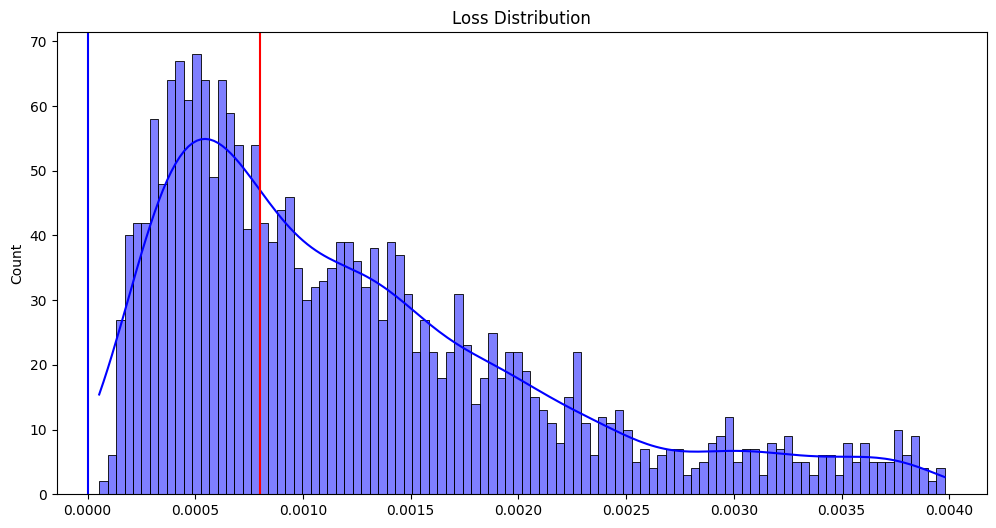

In [35]:
lower_threshold = 0.0
upper_threshold = 0.0008
plt.figure(figsize=(12,6))
plt.title('Loss Distribution')
sns.histplot( total_losses[total_losses < 0.004],bins=100,kde=True, color='blue')
plt.axvline(upper_threshold, 0.0, 10, color='r')
plt.axvline(lower_threshold, 0.0, 10, color='b')

In [39]:
def make_preds_and_classify(model, data_loader, threshold=1e-4):
    loss_dist = []
    y_true, y_pred = [], []
    y_scores = []
    model.eval()
    for x, y in data_loader:
        x = x.to(device)
        y_true.append(y)
        sample = model(x)
        loss = torch.nn.MSELoss()(x, sample)
        loss_dist.append(loss.item())
        if loss.item() < threshold:
            y_pred.append(0)
        else:
            y_pred.append(1)
        # np.exp(-losses) / np.sum(np.exp(-losses))

    losses = np.array(loss_dist)
    probs = np.exp(-losses) / np.sum(np.exp(-losses))
    
    m = np.median(losses)
    ad = np.abs(losses - m)
    mad = np.median(ad)
    probs2 =1/(1 + np.exp(-0.6745 * ad / mad))
    
    scaler = MinMaxScaler()
    scaler.fit(probs2.reshape(-1, 1))
    probs3 = scaler.transform(probs2.reshape(-1, 1))
    
    scaler = MinMaxScaler()
    scaler.fit(probs.reshape(-1, 1))
    probs4 = scaler.transform(probs2.reshape(-1, 1))
    
    probs5 = z = 1/(1 + np.exp(-losses))
    
    scaler = MinMaxScaler()
    scaler.fit(probs5.reshape(-1, 1))
    probs6 = scaler.transform(probs5.reshape(-1, 1))
    
    
    y_true = torch.cat(y_true, dim=0)
    num_ones = torch.sum(y_true == 1).item()
    print("Num ones", num_ones)
    
    acc, precision, recall, f1 = get_classification_metrics(y_true.numpy(), np.array(y_pred))
    
    print("Probs2:", get_probability_measures(y_true.numpy(), probs2))

    print("Probs2",get_lift_demotion_scores(y_true.numpy(), probs2,
                                                            num_samples=int(0.1 * num_ones),
                                                            verbose=False))
    
    print("Probs3:", get_probability_measures(y_true.numpy(), probs3))

    print("Probs3",get_lift_demotion_scores(y_true.numpy(), probs3,
                                                            num_samples=int(0.1 * num_ones),
                                                            verbose=False))
    print("Probs4:", get_probability_measures(y_true.numpy(), probs4))

    print("Probs4",get_lift_demotion_scores(y_true.numpy(), probs4,
                                                            num_samples=int(0.1 * num_ones),
                                                            verbose=False))
    
    print("Probs5:", get_probability_measures(y_true.numpy(), probs5))

    print("Probs5",get_lift_demotion_scores(y_true.numpy(), probs5,
                                                            num_samples=int(0.1 * num_ones),
                                                            verbose=False))
    
    print("Probs6:", get_probability_measures(y_true.numpy(), probs6))

    print("Probs6",get_lift_demotion_scores(y_true.numpy(), probs6,
                                                            num_samples=int(0.1 * num_ones),
                                                            verbose=False))
    
    brier, roc_auc, pr_auc = get_probability_measures(y_true.numpy(), probs)

    lift, demotion, weighted = get_lift_demotion_scores(y_true.numpy(), probs,
                                                            num_samples=int(0.1 * num_ones),
                                                            verbose=False)
    
    return acc, precision, recall, f1, brier, roc_auc, pr_auc, lift, demotion, weighted, losses
  

In [40]:
acc, precision, recall, f1, brier, roc_auc, pr_auc, lift, demotion, weighted, loss_dist = make_preds_and_classify(model, test_loader, 
                        threshold=0.0009)
print(f"[Test] Accuracy: {acc}, Precision: {precision}, Recall: {recall}, F1: {f1}\n"
                f"\t\tBrier score loss: {brier}, ROC-AUC: {roc_auc}, PR-AUC: {pr_auc}\n"
                f"\t\tLift: {lift}, Demotion: {demotion}, Weighted Score: {weighted}\n")

Num ones 311
Probs2: (0.4420707957433524, 0.5132686561205343, 0.13879862426828976)
Probs2 (0.16129032258064516, 0.9032258064516129, 0.3838709677419354)
Probs3: (0.24436561781061275, 0.5132686561205343, 0.13879862426828976)
Probs3 (0.16129032258064516, 0.9032258064516129, 0.3838709677419354)
Probs4: (None, 0.5132686561205343, 0.13879862426828976)
Probs4 (0.16129032258064516, 0.9032258064516129, 0.3838709677419354)
Probs5: (0.2504264234512246, 0.41995811029522423, 0.12269896669298824)
Probs5 (0.16129032258064516, 0.6451612903225806, 0.30645161290322576)
Probs6: (0.12881853617262062, 0.41995811029522423, 0.12269896669298824)
Probs6 (0.16129032258064516, 0.6451612903225806, 0.30645161290322576)
[Test] Accuracy: 0.4024948024948025, Precision: 0.09554597701149425, Recall: 0.42765273311897106, F1: 0.15619495008807985
		Brier score loss: 0.1292066181699853, ROC-AUC: 0.5800418897047759, PR-AUC: 0.18035400587202377
		Lift: 0.3548387096774194, Demotion: 0.8387096774193549, Weighted Score: 0.5



In [ ]:
np.percentile(loss_dist, 45)

In [ ]:
print(f"Test Mean: {statistics.mean(loss_dist)}, Median: {statistics.median(loss_dist)}")

In [ ]:
min(probs), max(probs)

In [ ]:
min(loss_dist), max(loss_dist)

In [ ]:
losses[:10], probs[:10]

In [ ]:
losses[-10:], probs[-10:]

In [ ]:
y_test